In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s, f  # s = spline term, f = factor (categorical)

load data

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
colnames = ["mpg","cylinders","displacement","horsepower","weight","acceleration","model_year","origin","car_name"]
df = pd.read_csv(url, delim_whitespace=True, names=colnames, na_values='?')
df = df.dropna()

/var/folders/5f/vq31x3ws3756twnm7dl48s3m0000gn/T/ipykernel_84969/812504448.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, names=colnames, na_values='?')


prepare data

In [4]:
X = df[["horsepower","weight","displacement","acceleration"]]
y = df["mpg"]

train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Fit Linear Regression

In [6]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

Fit GAM (with smooth for each predictor)

In [7]:
gam = LinearGAM(s(0) + s(1) + s(2) + s(3))
gam.gridsearch(X_train.values, y_train.values)  
# The .gridsearch chooses smoothing hyperparameters

y_pred_gam = gam.predict(X_test)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Compare performance

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
print("LR RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("GAM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gam)))
print("LR R2:", r2_score(y_test, y_pred_lr))
print("GAM R2:", r2_score(y_test, y_pred_gam))

LR RMSE: 4.3697559091032
GAM RMSE: 3.9173779033584784
LR R2: 0.6927894782580892
GAM R2: 0.7531047879989209


Plot smooth functions

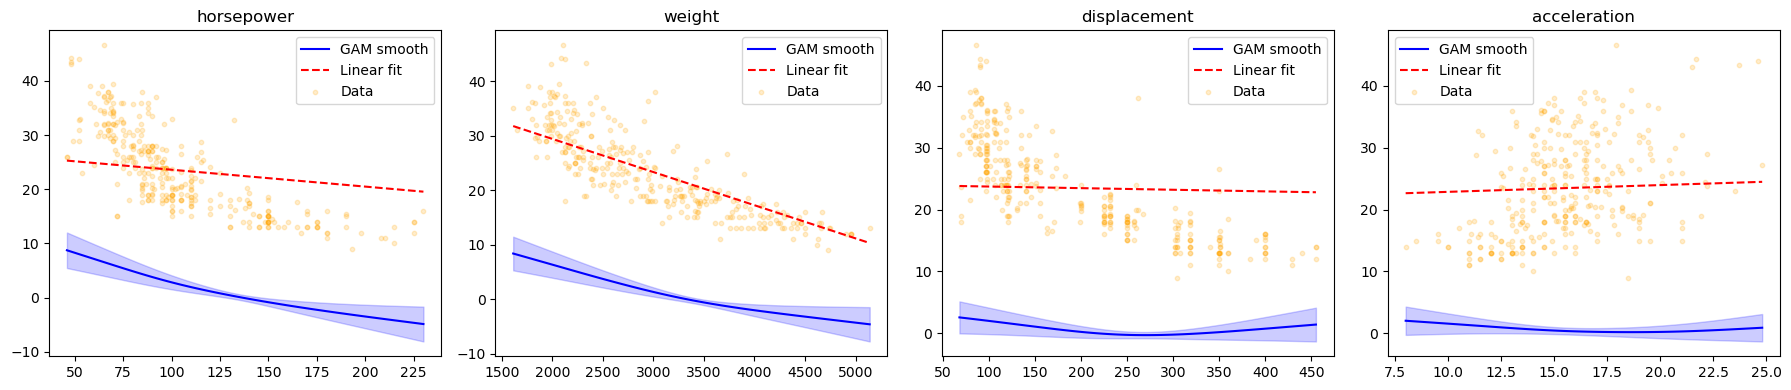

In [9]:
fig, axs = plt.subplots(1, X.shape[1], figsize=(18,4))

for i, var in enumerate(X.columns):
    # GAM curve 
    XX = gam.generate_X_grid(term=i, n=100)  
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    lower, upper = confi.T
    
    axs[i].plot(XX[:, i], pdep, color="blue", label="GAM smooth")
    axs[i].fill_between(XX[:, i], lower, upper, color="blue", alpha=0.2)
    
    # LR line
    # Take coefficient for this predictor
    beta_i = lr.coef_[i]
    intercept = lr.intercept_
    
    # To isolate effect of just one variable, fix others at their mean
    other_effect = sum(
        lr.coef_[j] * X_train.iloc[:, j].mean()
        for j in range(len(X.columns)) if j != i
    )
    
    lr_line = intercept + beta_i * XX[:, i] + other_effect
    axs[i].plot(XX[:, i], lr_line, "r--", label="Linear fit")
    
    # Raw data scatter for context 
    axs[i].scatter(X_train[var], y_train, alpha=0.2, s=10, color="orange", label="Data")
    
    axs[i].set_title(var)
    axs[i].legend()

plt.tight_layout()
plt.show()

The blue GAM curve is the smooth partial effect of each variable (centered around 0). The y-axis on the GAM plots is not mpg directly, it’s the effect size (contribution).

In [10]:
gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       7.863
Link Function:                     IdentityLink Log Likelihood:                                 -1144.9752
Number of Samples:                          313 AIC:                                             2307.6763
                                                AICc:                                            2308.2531
                                                GCV:                                               15.6857
                                                Scale:                                              14.978
                                                Pseudo R-Squared:                                   0.7583
Feature Function                  Lam

/var/folders/5f/vq31x3ws3756twnm7dl48s3m0000gn/T/ipykernel_84969/869333826.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()
